# AC II - UrbanSound8K Classification

### Como correr o codigo

Temos 5 notebooks:
> 1º - features.ipynb - Criação dos 6 datasets JSON: COM DATA IMBALANCE (features13.json, features26.json, features40.json); COM DATA AUGMENTATION (features_mfcc13.json, features_mfcc26.json, features_mfcc40.json)

> 2º - CNN_DataImbalance.ipynb e CNN_DataAugmented.ipynb - onde avaliamos os datasets através do modelo CNN

> 2º - LSTM_DataImbalance.ipynb e LSTM_DataAugmented.ipynb - onde avaliamos os datasets através do modelo LSTM

### Guide Line
#### Este trabalho divide-se em 3 Partes


1. Tratamento dos audios/dados para serem dados como input aos modelos.
2. Construção, otimização e avaliação dos modelos.
3. Bónus: Avaliar Robustez dos modelos.

### 1
Para construir um dataset a partir do audios usamos a biblioteca librosa.

Começamos por fazer resample dos audios para 441000 Hz.

Fizemos a transformação dos sinais para mfcc13, mfcc26, mfcc40 e melspectogram em decíbeis.

Ainda nesta parte, depois dos primeiros testes dos modelos, foi feito "Data Augmentation" e "Over Sampling" para diminuir o overfitting e tentar melhorar a performance dos modelos.

### 2

2ª parte do trabalho foi dividida em 3 etapas principais:

1. Construir os modelos 

- LSTM

- CNN

2. Hold out split

- Com este split, o modelo foi várias vezes testado com diferente número de epochs, layers, units, batch size e percentagem de dropout.

- Learning hyperparameters (learning rate, mini-batch size, number of epochs, number of layers).

- Regularization techniques to adopt (early stopping, weight regularization, dropout, data augmentation, oversampling).

3. Kfold Cross Validation para k=10

- Nesta parte fazemos uma avaliação mais robusta e pesada do modelo.


**Tivemos o cuidado de, durante o training set, não misturar folds para não treinar e testar mfccs semelhantes.**

### 3

O objetivo do Bonus é avaliar a robustez dos modelos implementados.

In [319]:
import pandas as pd
import os
import librosa
import numpy as np
from IPython.display import Audio
import matplotlib.pyplot as plt
import random
import soundfile as sf
import shutil

In [255]:
#Lemos o csv

df = pd.read_csv('metadata/UrbanSound8K.csv')

In [256]:
df

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
...,...,...,...,...,...,...,...,...
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn


### Lista com ficheiros (.wav)

Percorremos todos os folds e, para cada fold, criamos uma lista com os nomes dos audios: ficheiros (.wav).

No final, uma lista será criada, resultante da soma de todas as listas.

In [257]:
list1=[]
list2=[]
list3=[]
list4=[]
list5=[]
list6=[]
list7=[]
list8=[]
list9=[]
list10=[]

fold1 = 'audio/fold1'
list1 = os.listdir(fold1)

fold2 = 'audio/fold2'
list2 = os.listdir(fold2)

fold3 = 'audio/fold3'
list3 = os.listdir(fold3)

fold4 = 'audio/fold4'
list4 = os.listdir(fold4)

fold5 = 'audio/fold5'
list5 = os.listdir(fold5)

fold6 = 'audio/fold6'
list6 = os.listdir(fold6)

fold7 = 'audio/fold7'
list7 = os.listdir(fold7)

fold8 = 'audio/fold8'
list8 = os.listdir(fold8)

fold9 = 'audio/fold9'
list9 = os.listdir(fold9)

fold10 = 'audio/fold10'
list10 = os.listdir(fold10)

lista = list1 + list2 + list3 + list4 + list5 + list6 + list7 + list8 + list9 + list10

### Lista com todos os paths dos ficheiros (.wav)

A função path_class é responsável por criar o path, desde de onde me encontro até apenas o ficheiro (.wav).

In [258]:
def path_class(filename):
    excerpt = df[df['slice_file_name'] == filename]
    
    if not excerpt.empty:
        path_name = os.path.join('audio', 'fold'+str(excerpt.fold.values[0]), filename)
        return path_name
    
    else:
        return None

No código seguinte, aplico a função path_class à lista (que contém os nomes dos ficheiros (.wav) de todos os folds), resultando numa lista com os paths para todos os ficheiros (.wav).

In [327]:
path_list=[]
for i in lista:
    p = path_class(i)
    if (p!=None):
        path_list.append(p)

### Data Imbalance

A seguir, verificamos que o nosso dataset possui Data Imbalance.

Para resolver este problema, precisamos de realizar Data Augmentation.

In [260]:
df['class'].value_counts()

class
dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
engine_idling       1000
jackhammer          1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: count, dtype: int64

O próximo dicionário demonstra a quantidade de cada uma das classes nos diferentes folds, sendo do tipo:
**(class,fold):quantidade** .

In [398]:
df_counts = df.groupby(['class','fold']).size().reset_index(name='instances')
counts_dict = df_counts.set_index(['class','fold']).to_dict()['instances']

counts_dict

{('air_conditioner', 1): 100,
 ('air_conditioner', 2): 100,
 ('air_conditioner', 3): 100,
 ('air_conditioner', 4): 100,
 ('air_conditioner', 5): 100,
 ('air_conditioner', 6): 100,
 ('air_conditioner', 7): 100,
 ('air_conditioner', 8): 100,
 ('air_conditioner', 9): 100,
 ('air_conditioner', 10): 100,
 ('car_horn', 1): 36,
 ('car_horn', 2): 42,
 ('car_horn', 3): 43,
 ('car_horn', 4): 59,
 ('car_horn', 5): 98,
 ('car_horn', 6): 28,
 ('car_horn', 7): 28,
 ('car_horn', 8): 30,
 ('car_horn', 9): 32,
 ('car_horn', 10): 33,
 ('children_playing', 1): 100,
 ('children_playing', 2): 100,
 ('children_playing', 3): 100,
 ('children_playing', 4): 100,
 ('children_playing', 5): 100,
 ('children_playing', 6): 100,
 ('children_playing', 7): 100,
 ('children_playing', 8): 100,
 ('children_playing', 9): 100,
 ('children_playing', 10): 100,
 ('dog_bark', 1): 100,
 ('dog_bark', 2): 100,
 ('dog_bark', 3): 100,
 ('dog_bark', 4): 100,
 ('dog_bark', 5): 100,
 ('dog_bark', 6): 100,
 ('dog_bark', 7): 100,
 ('dog

### Data Augmentation

Os nossos modelos estavam a classificar com algum overfitting e a classificar bastante mal para algumas classes.

Sabemos que o dataset possui classes com pouca representação (data imbalance).

Por isso, decidimos aplicar data augmentation e oversampling apenas nessas classes, com o objetivo de termos, no total, perto de 1000 instâncias para cada uma dessas classes.

A função transformation é responsável por realizar esse processo de forma aleatória (mas com sentido e de acordo com as necessidades).

> Oversampling is a data augmentation technique used when dealing with imbalanced datasets where the majority class dominates the minority class.

> In data augmentation, the focus is on introducing variety and diversity into the training dataset by applying various transformations to the existing data.

**So we will use a mix of boths and apply it on the less represented classes.**

In [261]:
#1
def add_white_noise(signal,noise_factor):
    """
    Adiciona white noise ao audio.
    Recebe o original signal e aplica-lhe uma percentagem (noise factor) de random noise.
    
    Não aconselhavél factor>=0.5.
    
    Vamos adicionar white noise a instâncias que não são foreground (salience==1).
    Não usar quando salience == 2.
    """
    noise = np.random.normal(0,signal.std(),signal.size) #vector representing gaussian distibution to simlulate noise
    trans_signal = signal +noise*noise_factor
    return trans_signal

#2
def time_stretch(signal, stretch_rate):
    """
    Faz Speeding or Slowing (altera a velocidade) do audio sem alterar o seu Pitch.
    
    Não aconselhável factor>=0.5.
    """
    return librosa.effects.time_stretch(signal, rate=stretch_rate)

#3
def pitch_scale(signal, num_semitones, sr):
    """
    Muda o pitch do audio sem alterar a sua velocidade.
    
    Não abusar no numero de semitones(Este abuso pode ser preudicial principalmente quando estamos a trabalhar com instrumentos musicais)
    magens. Ainda assim, vamos adaptar a mesma ideia neste contexto).
    
    n_steps=10 é demasiado.
    """
    return librosa.effects.pitch_shift(signal, sr=sr, n_steps=num_semitones)


#4
def random_gain(signal, min_gain_factor, max_gain_factor):
    gain_factor = random.uniform(min_gain_factor,max_gain_factor)
    return signal*gain_factor

### Exemplo de uso de funções aplicadas no data augmentation para 1 só audio

In [262]:
audio_file = 'audio/fold1/77766-9-0-4.wav'

signal, previous_sr = librosa.load(audio_file, sr=None)

f = audio_file.split('/')
arquivo = f[-1]
salience = df[df['slice_file_name'] == arquivo].iloc[0]['salience']

print("Salience: ", salience)

Salience:  1


#### Audio Original

In [263]:
Audio(signal, rate=previous_sr)

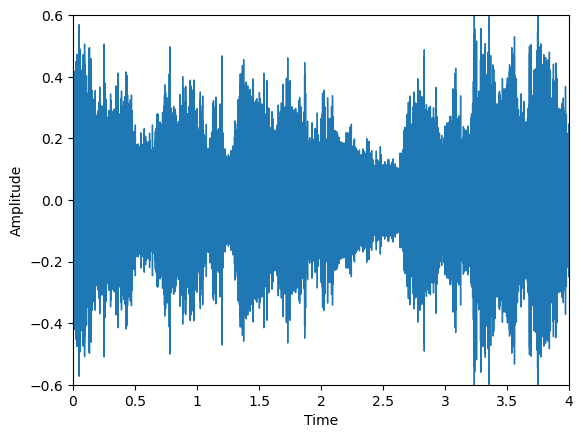

In [264]:
librosa.display.waveshow(signal)
plt.ylabel("Amplitude")
plt.xlim([0, 4])
plt.ylim([-0.6, 0.6]) 
plt.show()

#### Audio com white noise

In [265]:
white_signal = add_white_noise(signal,0.2)
Audio(white_signal, rate=sr)

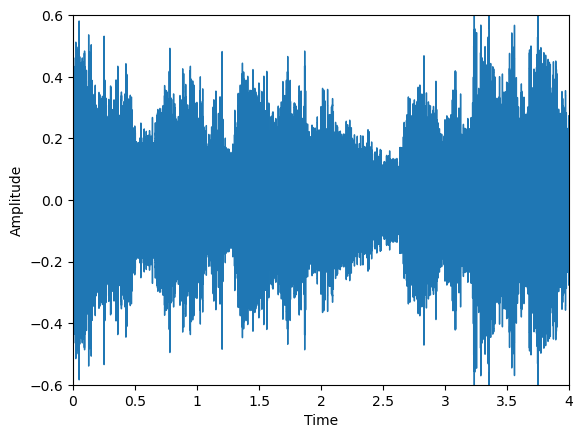

In [266]:
librosa.display.waveshow(white_signal)
plt.ylabel("Amplitude")
plt.xlim([0, 4])
plt.ylim([-0.6, 0.6]) 
plt.show()

#### Audio com time stretch

Como podemos observar, a função time stretch diminui o tamanho do audio (em vez de 4.0s tem 2.0s). Por tal acontecer, a seguir a aplicar a função, é necessário aumentar o tamanho do audio para 4.0s através da repetição do som. Fazemos isto na função transformation, onde vão acontecer as necessárias transformações do audio.

In [267]:
time_stretch_signal = time_stretch(signal, 1.8)
Audio(time_stretch_signal, rate=sr)

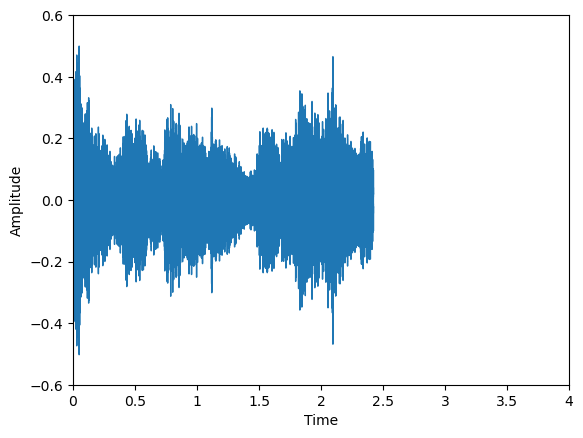

In [268]:
librosa.display.waveshow(time_stretch_signal)
plt.ylabel("Amplitude")
plt.xlim([0, 4])
plt.ylim([-0.6, 0.6]) 
plt.show()

#### Audio com pitch scale

In [269]:
scale_signal = pitch_scale(signal,9, sr)
Audio(scale_signal, rate=sr)

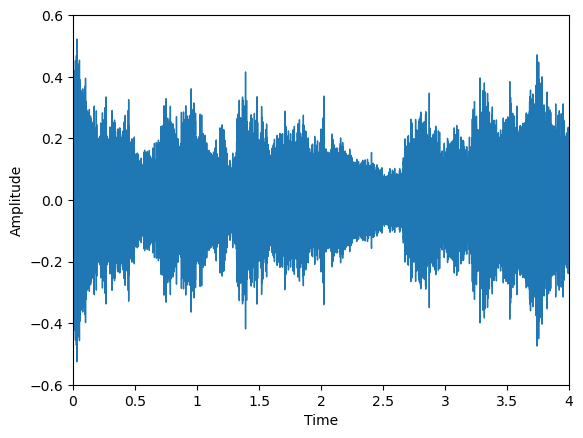

In [270]:
librosa.display.waveshow(scale_signal)
plt.ylabel("Amplitude")
plt.xlim([0, 4])
plt.ylim([-0.6, 0.6]) 
plt.show()

#### Audio com random gain

In [271]:
gain_audio = random_gain(signal, 1, 2)
Audio(gain_audio, rate=sr)

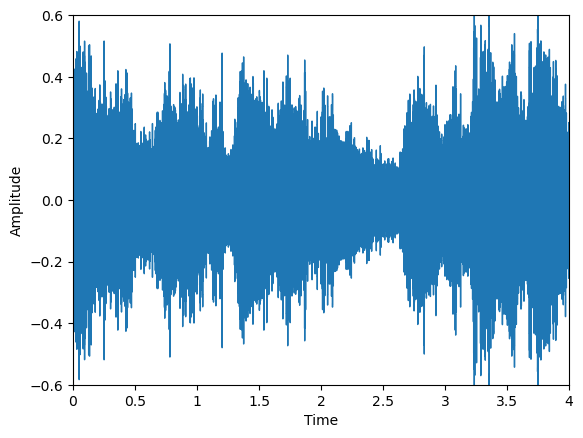

In [272]:
librosa.display.waveshow(gain_audio)
plt.ylabel("Amplitude")
plt.xlim([0, 4])
plt.ylim([-0.6,0.6])
plt.show()

In [273]:
def transformation(signal,sr,classe,salience,fold):
    """
    __Restriçoes__
    
    Salience: Se Salience == 2 não aplicamos funcão 1 "add_white noise"
                Porque um background sound, por si, já apresenta noise.
    
    Siren:  Como vai ser transformada poucas vezes, 
            vamos aplicar apenas data augmentation(func 1, 2, 3, 4) 
            e não oversampling(func 0) 

    
    Car_horn: pode sofrer qualquer transformação
    
    Gun_shot: pode sofrer qualquer transformação 
                
    
    -> Antes de começarmos a função vamos fazer um rand entre 0 e 100 se o return for >=45 a transformação ocorre,
    caso contrário salta todo o processo retornando apenas o próprio audio. Isto evita fazer sample apenas 
    nas primeiras n instancias consequtivas, (em cada folder existem audios consecutivos que advém do mesmo
    audio "pai".)
    
    ->Para Além disso também verificamos se a class para este folder já está preenchida e não é preciso mais 
            
    """
    
    #___0º___ tranforma ou não
    
    valor_aleatorio = random.randint(0, 100)
    
    # Verificar se o valor aleatório é maior ou igual a 45
    if valor_aleatorio < 45:
        return [signal] # ele próprio
    
    
    
    
    #___1º___ quantas transformações vão ser feitas(depende da frequencia de classes inicial)
    
    if classe == "siren":
        number_of_transformations = 1
        
    elif classe == "car_horn":
        number_of_transformations = random.choice([2,3])
        
    else:#gun_shot
        number_of_transformations = random.choice([2,3,4])
     
    
    #___2º___ podemos já atualizar no dicionário 
    #no fold do ficheiro (.wav) no momento retirarmos o number_of_transformations que fizemos
    
    if classe == "siren":
        siren[fold] -= number_of_transformations
        
    elif classe == "car_horn":
        car_horn[fold] -= number_of_transformations

    else:#gun_shot
        gun_shot[fold] -= number_of_transformations 

    
    #___3º___ quais funções podem ser escolhidas para transformação
    
    hipoteses = []
    
    if salience == np.int64(2):
        hipoteses = [0,2,3,4]
        
    else: 
        hipoteses = [0,1,2,3,4]
    
    
    #___4º___ inicializar a lista que vai ser retornada
    #flags siren?
    
    signals_lista = []
    
    
    while number_of_transformations!=0:  #para o numero de transfomações
        
        func = random.choice(hipoteses) #escolhemos um hipoteses das classes de hipoteses, random
        #0
        if func == 0:
            """
            repetimos apenas o audio, oversampling para aumentar o numero de classes.
            evita demasiadas transformações de sinal
            """
            trans_signal = signal
            signals_lista.append(trans_signal)
      
        #1
        elif func == 1:
            noise_factor = random.choice([0.3,0.15,0.2,0.25,0.35,0.4])
            trans_signal = add_white_noise(signal,noise_factor)
            signals_lista.append(trans_signal)

        #2  
        elif func == 2:
            stretch_rate = random.choice([0.3,0.2,0.25,0.35,0.4])
            trans_signal = time_stretch(signal, stretch_rate=stretch_rate)
            signals_lista.append(trans_signal)

        #3
        elif func == 3:
            num_semitones = random.choice([3,4,5,6,7,8,9,10])
            trans_signal = pitch_scale(signal,num_semitones, sr)
            signals_lista.append(trans_signal)

        #4
        elif func == 4:
            trans_signal = random_gain(signal, 5, 10)
            signals_lista.append(trans_signal)
            
        number_of_transformations -= 1
    
    return signals_lista

### Normalização dos Dados

Recorremos à normalização min-max para normalizar os dados.

In [274]:
# Normalização min-max

def normalize(y):
    min_val = np.min(y)
    max_val = np.max(y)
    ynormalized = (y - min_val) / (max_val - min_val)
    return ynormalized

Criamos um conjunto de dados que vai ser comum a todos os audios e que vai ser auxiliar na criação das features dos audios:
- sr: sample rate (vou fazer resample dos audios --> todos os audios vao ter o mesmo sample rate)
- hop_length: o número de samples para a próxima frame
- window_length: comprimento da window usada para, por exemplo, STFT(Short-time Fourier transform)
- n_fft: número de pontos na FFT(Fast Fourier Transform)
- mfcc_time_size: tamanho da dimensão temporal dos MFCCs --> se "mfcc_time_size" for 100, isso significa que os coeficientes MFCC estão a ser calculados para segmentos de tempo que contêm 100 amostras de áudio cada

In [275]:
sr = 44100
hop_length=round(sr*0.0125)
window_length=round(sr*0.023)
n_fft=2**14
mfcc_time_size = 4*sr//hop_length+1

### Features do Librosa

In [276]:
#Wave

def wave(y):
    ynormalized = normalize(y)
    return ynormalized

Sabemos que o número mínimo de mfccs é 13, que corresponde ao número dos coeficientes mais distintos entre eles.
Portanto, quando mfccs > 13, estamos a lidar com coeficientes com algumas semelhanças.
Contudo, não sabemos se estes coeficientes semelhantes podem ser ou não vantajosos para a classificação, pois podem fornecer informação necessária, com o contraposto de que quantos mais mfccs, mais tempo leva o treino do modelo.
Portanto, vamos experimentar com n_mfccs 13, 26 e 40.

A função mfcc13 dá-nos os **Mel-frequency cepstral coefficients** (MFCCs) com n_mfcc (number of MFCCs) 13.

In [277]:
#MFCC 13

n_mfcc=13

def mfcc13(y,n_mfcc=13):
    mfcc = librosa.feature.mfcc(y=y,sr=sr,n_fft=n_fft,hop_length=hop_length,win_length=window_length,n_mfcc=n_mfcc)
    y_mfcc13 = normalize(mfcc)
    return y_mfcc13

A função mfcc26 dá-nos os **Mel-frequency cepstral coefficients** (MFCCs) com n_mfcc (number of MFCCs) 26.

In [278]:
#MFCC 26

n_mfcc=26

def mfcc26(y,n_mfcc=26):
    mfcc = librosa.feature.mfcc(y=y,sr=sr,n_fft=n_fft,hop_length=hop_length,win_length=window_length,n_mfcc=n_mfcc)
    y_mfcc26 = normalize(mfcc)
    return y_mfcc26

A função mfcc40 dá-nos os **Mel-frequency cepstral coefficients** (MFCCs) com n_mfcc (number of MFCCs) 40.

In [279]:
#MFCC 40

n_mfcc=40

def mfcc40(y,n_mfcc=40):
    mfcc = librosa.feature.mfcc(y=y,sr=sr,n_fft=n_fft,hop_length=hop_length,win_length=window_length,n_mfcc=n_mfcc)
    y_mfcc40 = normalize(mfcc)
    return y_mfcc40

In [280]:
#MFCC delta

def mfcc_delta(y,n_mfcc=13):
    y_mfcc13 = librosa.feature.mfcc(y=y,sr=sr,n_fft=n_fft,hop_length=hop_length,win_length=window_length,n_mfcc=n_mfcc)
    mfcc_delta = librosa.feature.delta(y_mfcc13, width=3)
    y_mfcc_delta = normalize(mfcc_delta)
    
    return y_mfcc_delta

In [281]:
#MFCC delta 2

def mfcc_delta2(y, n_mfcc=13):
    y_mfcc13 = librosa.feature.mfcc(y=y,sr=sr,n_fft=n_fft,hop_length=hop_length,win_length=window_length,n_mfcc=n_mfcc)
    mfcc_delta2 = librosa.feature.delta(y_mfcc13, order=2, width=3)
    y_mfcc_delta2 = normalize(mfcc_delta2)
    
    return y_mfcc_delta2

In [282]:
#Spectrogram

def spectrogram(y):
    stft = librosa.core.stft(y, hop_length = hop_length, n_fft = n_fft)
    spectrogram = np.abs(stft)
    y_spectrogram = normalize(spectrogram)
    
    return y_spectrogram

In [283]:
#Logspectrogram

def logspectrogram(y):
    stft = librosa.core.stft(y, hop_length = hop_length, n_fft = n_fft)
    spectrogram = np.abs(stft)
    logspectrogram = librosa.amplitude_to_db(spectrogram)
    y_logspectrogram = normalize(logspectrogram)
    
    return y_logspectrogram

In [284]:
#Melspectrogram

def melspectrogram(y):
    stft = librosa.core.stft(y, hop_length = hop_length, n_fft = n_fft)
    spectrogram = np.abs(stft)
    melstft = librosa.feature.melspectrogram(S=spectrogram, sr=sr)
    y_melstft = normalize(melstft)
    
    return y_melstft

In [285]:
#Melspectrogram db

def melspectrogram_db(y):
    stft = librosa.core.stft(y, hop_length = hop_length, n_fft = n_fft)
    spectrogram = np.abs(stft)
    melstft = librosa.feature.melspectrogram(S=spectrogram, sr=sr, n_mels=128, fmax=8000)
    melstft_db = librosa.power_to_db(melstft, ref=np.max)
    y_melstft_db = normalize(melstft_db)
    
    return y_melstft_db

In [286]:
#Chromaspectrogram

def chromaspectrogram(y):
    stft = librosa.core.stft(y, hop_length = hop_length, n_fft = n_fft)
    spectrogram = np.abs(stft)
    chroma = librosa.feature.chroma_stft(y=y, S=spectrogram, sr=sr)
    y_chroma = normalize(chroma)
    
    return y_chroma

### Aplicação de algumas funções para 1 só audio resampled -> com sr=44100

In [287]:
audio_file = 'audio/fold1/77766-9-0-4.wav'

signal, previous_sr = librosa.load(audio_file, sr=None)

y_resample =librosa.resample(signal, orig_sr=previous_sr, target_sr=sr)

#### MFCC 13

In [288]:
ymfcc13 = mfcc13(y_resample)

In [289]:
ymfcc13.shape

(13, 321)

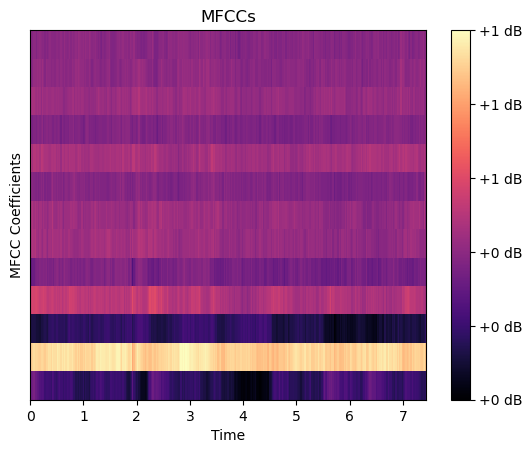

In [290]:
librosa.display.specshow(ymfcc13, x_axis='time')

# Add a colorbar
plt.colorbar(format="%+2.0f dB")

# Labeling and display
plt.xlabel("Time")
plt.ylabel("MFCC Coefficients")
plt.title("MFCCs")
plt.show()

#### MFCC 26

In [291]:
ymfcc26 = mfcc26(y_resample)

In [292]:
ymfcc26.shape

(26, 321)

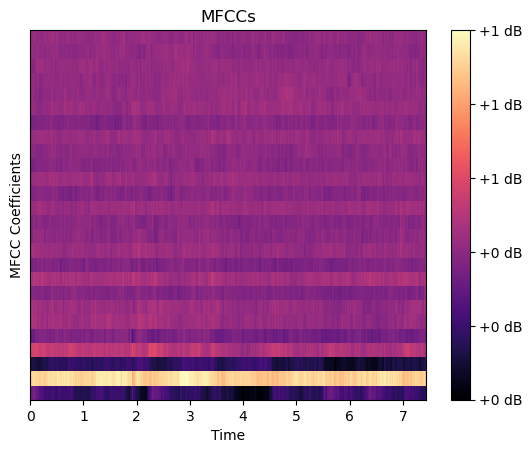

In [293]:
librosa.display.specshow(ymfcc26, x_axis='time')

# Add a colorbar
plt.colorbar(format="%+2.0f dB")

# Labeling and display
plt.xlabel("Time")
plt.ylabel("MFCC Coefficients")
plt.title("MFCCs")
plt.show()

#### MFCC 40

In [294]:
ymfcc40 = mfcc40(y_resample)

In [295]:
ymfcc40.shape

(40, 321)

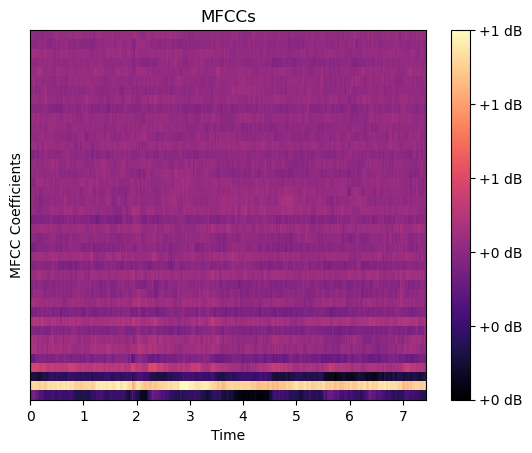

In [296]:
librosa.display.specshow(ymfcc40, x_axis='time')

# Add a colorbar
plt.colorbar(format="%+2.0f dB")

# Labeling and display
plt.xlabel("Time")
plt.ylabel("MFCC Coefficients")
plt.title("MFCCs")
plt.show()

#### MELSPECTROGRAM DECIBEIS

In [297]:
ymelspectrogram_db = melspectrogram_db(y_resample)

In [298]:
ymelspectrogram_db.shape

(128, 321)

[Text(0.5, 1.0, 'Mel-frequency spectrogram em decibeis')]

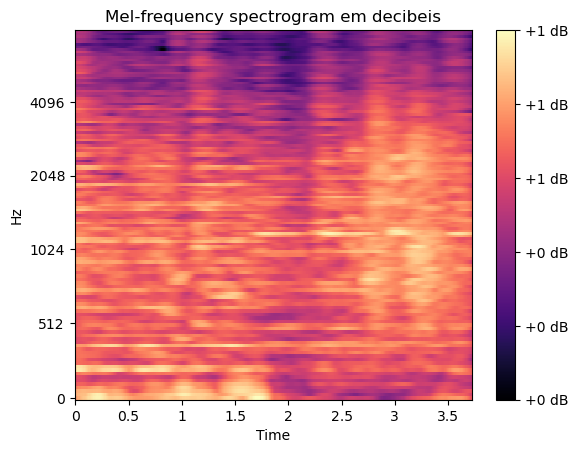

In [299]:
fig, ax = plt.subplots()
img = librosa.display.specshow(ymelspectrogram_db, x_axis='time', y_axis='mel', sr=sr, fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram em decibeis')

### Demonstração de resample de um audio

Fizemos resample a todos os audios, de modo que os audios tenham todos o mesmo sample rate(sr) = 44100.

In [300]:
audio_file = 'audio/fold1/180937-7-4-0.wav'

signal, previous_sr = librosa.load(audio_file, sr=None)

In [301]:
y_resample =librosa.resample(signal, orig_sr=previous_sr, target_sr=44100)

In [302]:
print(f'Sample Rate Original: {previous_sr} Hz')
print(f'Resample to: {sr} Hz')

Sample Rate Original: 96000 Hz
Resample to: 44100 Hz


### Demonstração de repetição de um audio

Fizemos repetição em alguns audios, aqueles que tivessem time < 4.0s, de modo a que todos os audios tenham o mesmo time.

In [303]:
audio_file = 'audio/fold7/99812-1-3-0.wav'

signal, previous_sr = librosa.load(audio_file, sr=None)

sr = 44100

y_resample =librosa.resample(signal, orig_sr=previous_sr, target_sr=sr)

In [304]:
#REPEAT

if len(signal)<4*sr:
    # Calculate the number of times to repeat the audio
    repeat = int(np.ceil(4 * sr / len(y_resample)))

    # Repeat the audio
    y_extended = np.tile(y_resample, repeat)

    # Trim the array to the desired duration
    y_extended = y_extended[:int(4 * sr)]

else:
    y_extended = y_resample

In [305]:
s = df.loc[df['slice_file_name'] == '99812-1-3-0.wav', 'start'].values[0]
e = df.loc[df['slice_file_name'] == '99812-1-3-0.wav', 'end'].values[0]
print(f'Tempo do audio original: {e-s} segundos')

Audio(data=y_resample, rate=sr)

Tempo do audio original: 2.1425450000000126 segundos


In [306]:
print(f'Tempo do audio original: {4.0} segundos')

Audio(data=y_extended, rate=sr)

Tempo do audio original: 4.0 segundos


### Criação de Datasets sem Data Augmentation

##### MFCC 13

In [364]:
#Data Frame para mfcc13

newdata1 = pd.DataFrame()
newdata1['mfcc13'] = [np.zeros((13, mfcc_time_size)) for _ in range(len(path_list))]

i=0
for f in path_list:
    f = f'{f}'
    
    y, previous_sr = librosa.load(f, sr=None)
    y_resample =librosa.resample(y, orig_sr=previous_sr, target_sr=sr)
    
    #REPEAT
    if len(y_resample)<4*sr:
        # Calculate the number of times to repeat the audio
        repeat = int(np.ceil(4 * sr / len(y_resample)))

        # Repeat the audio
        y_extended = np.tile(y_resample, repeat)

        # Trim the array to the desired duration
        y_extended = y_extended[:int(4 * sr)]

    else:
        y_extended = y_resample
        
    
    path_parts = f.split('/')
    arquivo = path_parts[-1] #dá-nos o nome do audio (.wav)
    
    #pesquisa no dataset UrbanSound8K.csv
    if arquivo in df['slice_file_name'].values:
        fold = df[df['slice_file_name'] == arquivo].iloc[0]['fold']
        salience = df[df['slice_file_name'] == arquivo].iloc[0]['salience']
        classID = df[df['slice_file_name'] == arquivo].iloc[0]['classID']
        
        #introduz os dados no dataframe
        newdata1.at[i, 'file'] = arquivo
        newdata1.at[i, 'salience'] = salience
        newdata1.at[i, 'fold'] = fold
        newdata1.at[i, 'classID'] = classID
                     
    
    # MFCCs 13
    newdata1.at[i, 'mfcc13'] = mfcc13(y_extended)
        
    i+=1

columns = ['file', 'salience', 'fold', 'mfcc13', 'classID']

newdata1 = newdata1[columns]

In [365]:
newdata1.to_json('features13.json')

In [366]:
d1 = pd.read_json('features13.json')

In [367]:
d1

,file,salience,fold,mfcc13,classID
0,135776-2-0-49.wav,2,1,"[[0.1043594405, 0.0525185205, 0.0584450252, 0....",2
1,46654-6-0-0.wav,1,1,"[[0.0, 0.026401408, 0.026924215300000002, 0.30...",6
2,57320-0-0-24.wav,2,1,"[[0.2571681142, 0.19033260640000002, 0.1936520...",0
3,134717-0-0-26.wav,1,1,"[[0.1350698918, 0.0285070594, 0.0413862392, 0....",0
4,174276-7-5-0.wav,1,1,"[[0.10389473290000001, 0.2066275626, 0.1831817...",7
...,...,...,...,...,...
8727,88121-8-0-0.wav,2,10,"[[0.0431582965, 0.031919945000000005, 0.038528...",8
8728,189982-0-0-42.wav,1,10,"[[0.0, 0.055268406900000004, 0.047489263100000...",0
8729,74364-8-1-7.wav,2,10,"[[0.033702936, 0.080786258, 0.1064587533, 0.09...",8
8730,99192-4-0-7.wav,1,10,"[[0.1716143936, 0.31627538800000005, 0.2538642...",4


##### MFCC 26

In [368]:
#Data Frame para mfcc26

newdata2 = pd.DataFrame()
newdata2['mfcc26'] = [np.zeros((26, mfcc_time_size)) for _ in range(len(path_list))]

i=0
for f in path_list:
    f = f'{f}'
    
    y, previous_sr = librosa.load(f, sr=None)
    y_resample =librosa.resample(y, orig_sr=previous_sr, target_sr=sr)
    
    #REPEAT
    if len(y_resample)<4*sr:
        # Calculate the number of times to repeat the audio
        repeat = int(np.ceil(4 * sr / len(y_resample)))

        # Repeat the audio
        y_extended = np.tile(y_resample, repeat)

        # Trim the array to the desired duration
        y_extended = y_extended[:int(4 * sr)]

    else:
        y_extended = y_resample
        
    
    path_parts = f.split('/')
    arquivo = path_parts[-1]
    
    if arquivo in df['slice_file_name'].values:
        fold = df[df['slice_file_name'] == arquivo].iloc[0]['fold']
        salience = df[df['slice_file_name'] == arquivo].iloc[0]['salience']
        classID = df[df['slice_file_name'] == arquivo].iloc[0]['classID']
        

        newdata2.at[i, 'file'] = arquivo
        newdata2.at[i, 'salience'] = salience
        newdata2.at[i, 'fold'] = fold
        newdata2.at[i, 'classID'] = classID
                     
            
    # MFCCs 26
    newdata2.at[i, 'mfcc26'] = mfcc26(y_extended)
        
    i+=1

columns = ['file', 'salience', 'fold', 'mfcc26', 'classID']

newdata2 = newdata2[columns]

In [369]:
newdata2.to_json('features26.json')

In [370]:
d2 = pd.read_json('features26.json')

In [371]:
d2

,file,salience,fold,mfcc26,classID
0,135776-2-0-49.wav,2,1,"[[0.1043594405, 0.0525185205, 0.0584450252, 0....",2
1,46654-6-0-0.wav,1,1,"[[0.0, 0.026401408, 0.026924215300000002, 0.30...",6
2,57320-0-0-24.wav,2,1,"[[0.2571681142, 0.19033260640000002, 0.1936520...",0
3,134717-0-0-26.wav,1,1,"[[0.1350698918, 0.0285070594, 0.0413862392, 0....",0
4,174276-7-5-0.wav,1,1,"[[0.10389473290000001, 0.2066275626, 0.1831817...",7
...,...,...,...,...,...
8727,88121-8-0-0.wav,2,10,"[[0.0431582965, 0.031919945000000005, 0.038528...",8
8728,189982-0-0-42.wav,1,10,"[[0.0, 0.055268406900000004, 0.047489263100000...",0
8729,74364-8-1-7.wav,2,10,"[[0.033702936, 0.080786258, 0.1064587533, 0.09...",8
8730,99192-4-0-7.wav,1,10,"[[0.1716143936, 0.31627538800000005, 0.2538642...",4


##### MFCC 40

In [372]:
#Data Frame para mfcc40

newdata3 = pd.DataFrame()
newdata3['mfcc40'] = [np.zeros((40, mfcc_time_size)) for _ in range(len(path_list))]

i=0
for f in path_list:
    f = f'{f}'
    
    y, previous_sr = librosa.load(f, sr=None)
    y_resample =librosa.resample(y, orig_sr=previous_sr, target_sr=sr)
    
    #REPEAT
    if len(y_resample)<4*sr:
        # Calculate the number of times to repeat the audio
        repeat = int(np.ceil(4 * sr / len(y_resample)))

        # Repeat the audio
        y_extended = np.tile(y_resample, repeat)

        # Trim the array to the desired duration
        y_extended = y_extended[:int(4 * sr)]

    else:
        y_extended = y_resample
        
    
    path_parts = f.split('/')
    arquivo = path_parts[-1]
    
    if arquivo in df['slice_file_name'].values:
        fold = df[df['slice_file_name'] == arquivo].iloc[0]['fold']
        salience = df[df['slice_file_name'] == arquivo].iloc[0]['salience']
        classID = df[df['slice_file_name'] == arquivo].iloc[0]['classID']
        

        newdata3.at[i, 'file'] = arquivo
        newdata3.at[i, 'salience'] = salience
        newdata3.at[i, 'fold'] = fold
        newdata3.at[i, 'classID'] = classID
                     
    
    # MFCCs 40
    newdata3.at[i, 'mfcc40'] = mfcc40(y_extended)
        
    i+=1

columns = ['file', 'salience', 'fold', 'mfcc40', 'classID']

newdata3 = newdata3[columns]

In [373]:
newdata3.to_json('features40.json')

In [374]:
d3 = pd.read_json('features40.json')

In [375]:
d3

,file,salience,fold,mfcc40,classID
0,135776-2-0-49.wav,2,1,"[[0.1043594405, 0.0525185205, 0.0584450252, 0....",2
1,46654-6-0-0.wav,1,1,"[[0.0, 0.026401408, 0.026924215300000002, 0.30...",6
2,57320-0-0-24.wav,2,1,"[[0.2571681142, 0.19033260640000002, 0.1936520...",0
3,134717-0-0-26.wav,1,1,"[[0.1350698918, 0.0285070594, 0.0413862392, 0....",0
4,174276-7-5-0.wav,1,1,"[[0.10389473290000001, 0.2066275626, 0.1831817...",7
...,...,...,...,...,...
8727,88121-8-0-0.wav,2,10,"[[0.0431582965, 0.031919945000000005, 0.038528...",8
8728,189982-0-0-42.wav,1,10,"[[0.0, 0.055268406900000004, 0.047489263100000...",0
8729,74364-8-1-7.wav,2,10,"[[0.033702936, 0.080786258, 0.1064587533, 0.09...",8
8730,99192-4-0-7.wav,1,10,"[[0.1716143936, 0.31627538800000005, 0.2538642...",4


### Criação de Datasets com Data Augmentation

##### MFCC 13

Para a criação dos ficheiros resultantes do Data Augmentation, associamos um **j**, tal que os ficheiros sejam do género: **f"augmented{j}"**.

In [345]:
j=0

In [346]:
int1 = np.int64(1)
int2 = np.int64(2)
int3 = np.int64(3)
int4 = np.int64(4)
int5 = np.int64(5)
int6 = np.int64(6)
int7 = np.int64(7)
int8 = np.int64(8)
int9 = np.int64(9)
int10 = np.int64(10)


# ao longo do transformation atualizamos estes dicionários
car_horn = {int1:64, int2:58, int3:57, int4:41, int5:2, int6:72, int7:72, int8:70, int9:68, int10:67}
gun_shot = {int1:65, int2:65, int3:64, int4:62, int5:60, int6:54, int7:49, int8:70, int9:69, int10:68}
siren    = {int1:0, int2:0, int3:0, int4:0, int5:20, int6:19, int7:17, int8:0, int9:0, int10:15}

In [347]:
#Data Frame do mfcc13

data1 = pd.DataFrame(columns = ['file', 'transformed', 'salience', 'fold', 'classID'])
data1['mfcc13'] = [np.zeros((13, mfcc_time_size)) for _ in range(len(path_list))]

i=0
data1.reset_index(drop=True, inplace=True)
for f in path_list:
    f = f'{f}'
    
    #AUDIO NORMAL
    
    y, previous_sr = librosa.load(f, sr=None)
    y_resample =librosa.resample(y, orig_sr=previous_sr, target_sr=sr)
    
    #REPEAT
    if len(y_resample)<4*sr:
        # Calculate the number of times to repeat the audio
        repeat = int(np.ceil(4 * sr / len(y_resample)))

        # Repeat the audio
        y_extended = np.tile(y_resample, repeat)

        # Trim the array to the desired duration
        y_extended = y_extended[:int(4 * sr)]

    else:
        y_extended = y_resample
        
    path_parts = f.split('/')
    arquivo = path_parts[-1]
    
    if arquivo in df['slice_file_name'].values:
        fold = df[df['slice_file_name'] == arquivo].iloc[0]['fold']
        salience = df[df['slice_file_name'] == arquivo].iloc[0]['salience']
        classe = df[df['slice_file_name'] == arquivo].iloc[0]['class']
        classID = df[df['slice_file_name'] == arquivo].iloc[0]['classID']
        
        
        data1.at[i, 'file'] = arquivo
        data1.at[i, 'salience'] = salience
        data1.at[i, 'fold'] = fold
        data1.at[i, 'classID'] = classID
        data1.at[i,'transformed'] = "false"
        data1.at[i, 'mfcc13'] = mfcc13(y_extended)
        i+=1

        
    #DATA AUGMENTATION
            
    if ((classe=="car_horn" and car_horn[fold]>0)or(classe=="gun_shot" and gun_shot[fold]>0)or(classe=="siren" and siren[fold]>0)):
        list_augmented = transformation(y_resample,sr,classe,salience,fold)
    
        #REPEAT
        for y_augmented in list_augmented:
            y_extendedj = "y_extended" + str(j)
            if len(y_augmented)<4*sr:
                # Calculate the number of times to repeat the audio
                repeat = int(np.ceil(4 * sr / len(y_augmented)))

                # Repeat the audio
                y_extendedj = np.tile(y_augmented, repeat)

                # Trim the array to the desired duration
                y_extendedj = y_extendedj[:int(4 * sr)]

            else:
                y_extendedj = y_augmented
            
            
            sf.write(f"augmented{j}.wav",y_extendedj,sr)
            
            #Guardo os ficheiros augmented criados numa pasta data1
            destino = "data1"
            shutil.move(f"augmented{j}.wav", destino)
            
            archive = f'augmented{j}.wav'
            data1.at[i, 'file'] = archive
            data1.at[i, 'salience'] = salience
            data1.at[i, 'fold'] = fold
            data1.at[i, 'classID'] = classID
            if np.array_equal(y_extendedj,y_extended):
                data1.at[i,'transformed'] = "false"
            else:
                data1.at[i,'transformed'] = "true"
            data1.at[i, 'mfcc13'] = mfcc13(y_extendedj)
            
            j+=1
            i+=1

data1

,file,transformed,salience,fold,classID,mfcc13
0,135776-2-0-49.wav,false,2,1,2,"[[0.10435944, 0.05251852, 0.058445025, 0.06104..."
1,46654-6-0-0.wav,false,1,1,6,"[[0.0, 0.026401408, 0.026924215, 0.30824995, 0..."
2,augmented0.wav,true,1,1,6,"[[0.0, 0.032100294, 0.032735955, 0.37478703, 1..."
3,augmented1.wav,true,1,1,6,"[[0.046307243, 0.07692103, 0.077527285, 0.4037..."
4,augmented2.wav,true,1,1,6,"[[0.0, 0.13802069596184643, 0.1238836152120307..."
...,...,...,...,...,...,...
10104,88121-8-0-0.wav,false,2,10,8,"[[0.043158296, 0.031919945, 0.03852885, 0.0317..."
10105,189982-0-0-42.wav,false,1,10,0,"[[0.0, 0.055268407, 0.047489263, 0.05047143, 0..."
10106,74364-8-1-7.wav,false,2,10,8,"[[0.033702936, 0.08078626, 0.10645875, 0.09591..."
10107,99192-4-0-7.wav,false,1,10,4,"[[0.1716144, 0.3162754, 0.2538643, 0.36639214,..."


In [348]:
data1.to_json('features_mfcc13.json')

In [349]:
df1 = pd.read_json('features_mfcc13.json')

In [350]:
df1

,file,transformed,salience,fold,classID,mfcc13
0,135776-2-0-49.wav,false,2,1,2,"[[0.1043594405, 0.0525185205, 0.0584450252, 0...."
1,46654-6-0-0.wav,false,1,1,6,"[[0.0, 0.026401408, 0.026924215300000002, 0.30..."
2,augmented0.wav,true,1,1,6,"[[0.0, 0.0321002938, 0.032735955000000004, 0.3..."
3,augmented1.wav,true,1,1,6,"[[0.0463072434, 0.0769210309, 0.0775272846, 0...."
4,augmented2.wav,true,1,1,6,"[[0.0, 0.138020696, 0.1238836152, 0.2048886231..."
...,...,...,...,...,...,...
10104,88121-8-0-0.wav,false,2,10,8,"[[0.0431582965, 0.031919945000000005, 0.038528..."
10105,189982-0-0-42.wav,false,1,10,0,"[[0.0, 0.055268406900000004, 0.047489263100000..."
10106,74364-8-1-7.wav,false,2,10,8,"[[0.033702936, 0.080786258, 0.1064587533, 0.09..."
10107,99192-4-0-7.wav,false,1,10,4,"[[0.1716143936, 0.31627538800000005, 0.2538642..."


Com o Data Augmentation, já não verificamos Data Imbalance.

In [378]:
df1['classID'].value_counts()

classID
6    1079
8    1046
2    1000
0    1000
7    1000
4    1000
5    1000
3    1000
9    1000
1     984
Name: count, dtype: int64

Em comparação com o dataset original (df) ...

In [383]:
df['classID'].value_counts()

classID
3    1000
2    1000
0    1000
9    1000
5    1000
7    1000
4    1000
8     929
1     429
6     374
Name: count, dtype: int64

##### MFCC 26

In [351]:
jinit = j

In [352]:
int1 = np.int64(1)
int2 = np.int64(2)
int3 = np.int64(3)
int4 = np.int64(4)
int5 = np.int64(5)
int6 = np.int64(6)
int7 = np.int64(7)
int8 = np.int64(8)
int9 = np.int64(9)
int10 = np.int64(10)


# ao longo do transformation atualizamos estes dicionários
car_horn = {int1:64, int2:58, int3:57, int4:41, int5:2, int6:72, int7:72, int8:70, int9:68, int10:67}
gun_shot = {int1:65, int2:65, int3:64, int4:62, int5:60, int6:54, int7:49, int8:70, int9:69, int10:68}
siren    = {int1:0, int2:0, int3:0, int4:0, int5:20, int6:19, int7:17, int8:0, int9:0, int10:15}

In [353]:
data2 = pd.DataFrame(columns = ['file', 'transformed', 'salience', 'fold', 'classID'])
data2['mfcc26'] = [np.zeros((26, mfcc_time_size)) for _ in range(len(path_list))]

i=0
data2.reset_index(drop=True, inplace=True)
for f in path_list:
    f = f'{f}'
    
    #AUDIO NORMAL
    
    y, previous_sr = librosa.load(f, sr=None)
    y_resample =librosa.resample(y, orig_sr=previous_sr, target_sr=sr)
    
    #REPEAT
    if len(y_resample)<4*sr:
        # Calculate the number of times to repeat the audio
        repeat = int(np.ceil(4 * sr / len(y_resample)))

        # Repeat the audio
        y_extended = np.tile(y_resample, repeat)

        # Trim the array to the desired duration
        y_extended = y_extended[:int(4 * sr)]

    else:
        y_extended = y_resample
        
    path_parts = f.split('/')
    arquivo = path_parts[-1]
    
    if arquivo in df['slice_file_name'].values:
        fold = df[df['slice_file_name'] == arquivo].iloc[0]['fold']
        salience = df[df['slice_file_name'] == arquivo].iloc[0]['salience']
        classe = df[df['slice_file_name'] == arquivo].iloc[0]['class']
        classID = df[df['slice_file_name'] == arquivo].iloc[0]['classID']
        
        
        data2.at[i, 'file'] = arquivo
        data2.at[i, 'salience'] = salience
        data2.at[i, 'fold'] = fold
        data2.at[i, 'classID'] = classID
        data2.at[i,'transformed'] = "false"
        data2.at[i, 'mfcc26'] = mfcc26(y_extended)
        i+=1

        
    #DATA AUGMENTATION
            
    if ((classe=="car_horn" and car_horn[fold]>0)or(classe=="gun_shot" and gun_shot[fold]>0)or(classe=="siren" and siren[fold]>0)):
        list_augmented = transformation(y_resample,sr,classe,salience,fold)
    
        #REPEAT
        for y_augmented in list_augmented:
            y_extendedj = "y_extended" + str(jinit)
            if len(y_augmented)<4*sr:
                # Calculate the number of times to repeat the audio
                repeat = int(np.ceil(4 * sr / len(y_augmented)))

                # Repeat the audio
                y_extendedj = np.tile(y_augmented, repeat)

                # Trim the array to the desired duration
                y_extendedj = y_extendedj[:int(4 * sr)]

            else:
                y_extendedj = y_augmented
            
            
            sf.write(f"augmented{jinit}.wav",y_extendedj,sr)
            
            #Guardo os ficheiros augmented criados numa pasta data2
            destino = "data2"
            shutil.move(f"augmented{jinit}.wav", destino)
            
            archive = f'augmented{jinit}.wav'
            data2.at[i, 'file'] = archive
            data2.at[i, 'salience'] = salience
            data2.at[i, 'fold'] = fold
            data2.at[i, 'classID'] = classID
            if np.array_equal(y_extendedj,y_extended):
                data2.at[i,'transformed'] = "false"
            else:
                data2.at[i,'transformed'] = "true"
            data2.at[i, 'mfcc26'] = mfcc26(y_extendedj)
            
            jinit+=1
            i+=1

data2

,file,transformed,salience,fold,classID,mfcc26
0,135776-2-0-49.wav,false,2,1,2,"[[0.10435944, 0.05251852, 0.058445025, 0.06104..."
1,46654-6-0-0.wav,false,1,1,6,"[[0.0, 0.026401408, 0.026924215, 0.30824995, 0..."
2,augmented1377.wav,false,1,1,6,"[[0.0, 0.026401408, 0.026924215, 0.30824995, 0..."
3,57320-0-0-24.wav,false,2,1,0,"[[0.2571681, 0.1903326, 0.19365205, 0.2478302,..."
4,134717-0-0-26.wav,false,1,1,0,"[[0.13506989, 0.02850706, 0.04138624, 0.060279..."
...,...,...,...,...,...,...
10113,88121-8-0-0.wav,false,2,10,8,"[[0.043158296, 0.031919945, 0.03852885, 0.0317..."
10114,189982-0-0-42.wav,false,1,10,0,"[[0.0, 0.055268407, 0.047489263, 0.05047143, 0..."
10115,74364-8-1-7.wav,false,2,10,8,"[[0.033702936, 0.08078626, 0.10645875, 0.09591..."
10116,99192-4-0-7.wav,false,1,10,4,"[[0.1716144, 0.3162754, 0.2538643, 0.36639214,..."


In [354]:
data2.to_json('features_mfcc26.json')

In [355]:
df2 = pd.read_json('features_mfcc26.json')

In [356]:
df2

,file,transformed,salience,fold,classID,mfcc26
0,135776-2-0-49.wav,false,2,1,2,"[[0.1043594405, 0.0525185205, 0.0584450252, 0...."
1,46654-6-0-0.wav,false,1,1,6,"[[0.0, 0.026401408, 0.026924215300000002, 0.30..."
2,augmented1377.wav,false,1,1,6,"[[0.0, 0.026401408, 0.026924215300000002, 0.30..."
3,57320-0-0-24.wav,false,2,1,0,"[[0.2571681142, 0.19033260640000002, 0.1936520..."
4,134717-0-0-26.wav,false,1,1,0,"[[0.1350698918, 0.0285070594, 0.0413862392, 0...."
...,...,...,...,...,...,...
10113,88121-8-0-0.wav,false,2,10,8,"[[0.0431582965, 0.031919945000000005, 0.038528..."
10114,189982-0-0-42.wav,false,1,10,0,"[[0.0, 0.055268406900000004, 0.047489263100000..."
10115,74364-8-1-7.wav,false,2,10,8,"[[0.033702936, 0.080786258, 0.1064587533, 0.09..."
10116,99192-4-0-7.wav,false,1,10,4,"[[0.1716143936, 0.31627538800000005, 0.2538642..."


Com o Data Augmentation, já não verificamos Data Imbalance.

In [379]:
df2['classID'].value_counts()

classID
8    1096
6    1083
2    1000
0    1000
7    1000
4    1000
5    1000
3    1000
9    1000
1     939
Name: count, dtype: int64

Em comparação com o dataset original (df) ...

In [382]:
df['classID'].value_counts()

classID
3    1000
2    1000
0    1000
9    1000
5    1000
7    1000
4    1000
8     929
1     429
6     374
Name: count, dtype: int64

##### MFCC 40

In [357]:
jinit2 = jinit

In [358]:
int1 = np.int64(1)
int2 = np.int64(2)
int3 = np.int64(3)
int4 = np.int64(4)
int5 = np.int64(5)
int6 = np.int64(6)
int7 = np.int64(7)
int8 = np.int64(8)
int9 = np.int64(9)
int10 = np.int64(10)


# ao longo do transformation atualizamos estes dicionários
car_horn = {int1:64, int2:58, int3:57, int4:41, int5:2, int6:72, int7:72, int8:70, int9:68, int10:67}
gun_shot = {int1:65, int2:65, int3:64, int4:62, int5:60, int6:54, int7:49, int8:70, int9:69, int10:68}
siren    = {int1:0, int2:0, int3:0, int4:0, int5:20, int6:19, int7:17, int8:0, int9:0, int10:15}

In [360]:
#Data Frame do mfcc40

data3 = pd.DataFrame(columns = ['file', 'transformed', 'salience', 'fold', 'classID'])
data3['mfcc40'] = [np.zeros((40, mfcc_time_size)) for _ in range(len(path_list))]

i=0
data3.reset_index(drop=True, inplace=True)
for f in path_list:
    f = f'{f}'
    
    #AUDIO NORMAL
    y, previous_sr = librosa.load(f, sr=None)
    y_resample =librosa.resample(y, orig_sr=previous_sr, target_sr=sr)
    
    #REPEAT
    if len(y_resample)<4*sr:
        # Calculate the number of times to repeat the audio
        repeat = int(np.ceil(4 * sr / len(y_resample)))

        # Repeat the audio
        y_extended = np.tile(y_resample, repeat)

        # Trim the array to the desired duration
        y_extended = y_extended[:int(4 * sr)]

    else:
        y_extended = y_resample
        
    path_parts = f.split('/')
    arquivo = path_parts[-1]
    
    if arquivo in df['slice_file_name'].values:
        fold = df[df['slice_file_name'] == arquivo].iloc[0]['fold']
        salience = df[df['slice_file_name'] == arquivo].iloc[0]['salience']
        classe = df[df['slice_file_name'] == arquivo].iloc[0]['class']
        classID = df[df['slice_file_name'] == arquivo].iloc[0]['classID']
        
        
        data3.at[i, 'file'] = arquivo
        data3.at[i, 'salience'] = salience
        data3.at[i, 'fold'] = fold
        data3.at[i, 'classID'] = classID
        data3.at[i,'transformed'] = "false"
        data3.at[i, 'mfcc40'] = mfcc40(y_extended)
        i+=1

        
    #DATA AUGMENTATION
            
    if ((classe=="car_horn" and car_horn[fold]>0)or(classe=="gun_shot" and gun_shot[fold]>0)or(classe=="siren" and siren[fold]>0)):
        list_augmented = transformation(y_resample,sr,classe,salience,fold)
    
        #REPEAT
        for y_augmented in list_augmented:
            y_extendedj = "y_extended" + str(jinit2)
            if len(y_augmented)<4*sr:
                # Calculate the number of times to repeat the audio
                repeat = int(np.ceil(4 * sr / len(y_augmented)))

                # Repeat the audio
                y_extendedj = np.tile(y_augmented, repeat)

                # Trim the array to the desired duration
                y_extendedj = y_extendedj[:int(4 * sr)]

            else:
                y_extendedj = y_augmented
            
            
            sf.write(f"augmented{jinit2}.wav",y_extendedj,sr)
            
            #Guardo os ficheiros augmented criados numa pasta data3
            destino = "data3"
            shutil.move(f"augmented{jinit2}.wav", destino)
            
            archive = f'augmented{jinit2}.wav'
            data3.at[i, 'file'] = archive
            data3.at[i, 'salience'] = salience
            data3.at[i, 'fold'] = fold
            data3.at[i, 'classID'] = classID
            if np.array_equal(y_extendedj,y_extended):
                data3.at[i,'transformed'] = "false"
            else:
                data3.at[i,'transformed'] = "true"
            data3.at[i, 'mfcc40'] = mfcc40(y_extendedj)
            
            jinit2+=1
            i+=1

data3

,file,transformed,salience,fold,classID,mfcc40
0,135776-2-0-49.wav,false,2,1,2,"[[0.10435944, 0.05251852, 0.058445025, 0.06104..."
1,46654-6-0-0.wav,false,1,1,6,"[[0.0, 0.026401408, 0.026924215, 0.30824995, 0..."
2,augmented3397.wav,false,1,1,6,"[[0.0, 0.026401408, 0.026924215, 0.30824995, 0..."
3,57320-0-0-24.wav,false,2,1,0,"[[0.2571681, 0.1903326, 0.19365205, 0.2478302,..."
4,134717-0-0-26.wav,false,1,1,0,"[[0.13506989, 0.02850706, 0.04138624, 0.060279..."
...,...,...,...,...,...,...
9538,88121-8-0-0.wav,false,2,10,8,"[[0.043158296, 0.031919945, 0.03852885, 0.0317..."
9539,189982-0-0-42.wav,false,1,10,0,"[[0.0, 0.055268407, 0.047489263, 0.05047143, 0..."
9540,74364-8-1-7.wav,false,2,10,8,"[[0.033702936, 0.08078626, 0.10645875, 0.09591..."
9541,99192-4-0-7.wav,false,1,10,4,"[[0.1716144, 0.3162754, 0.2538643, 0.36639214,..."


In [361]:
data3.to_json('features_mfcc40.json')

In [362]:
df3 = pd.read_json('features_mfcc40.json')

In [363]:
df3

,file,transformed,salience,fold,classID,mfcc40
0,135776-2-0-49.wav,false,2,1,2,"[[0.1043594405, 0.0525185205, 0.0584450252, 0...."
1,46654-6-0-0.wav,false,1,1,6,"[[0.0, 0.026401408, 0.026924215300000002, 0.30..."
2,augmented3397.wav,false,1,1,6,"[[0.0, 0.026401408, 0.026924215300000002, 0.30..."
3,57320-0-0-24.wav,false,2,1,0,"[[0.2571681142, 0.19033260640000002, 0.1936520..."
4,134717-0-0-26.wav,false,1,1,0,"[[0.1350698918, 0.0285070594, 0.0413862392, 0...."
...,...,...,...,...,...,...
9538,88121-8-0-0.wav,false,2,10,8,"[[0.0431582965, 0.031919945000000005, 0.038528..."
9539,189982-0-0-42.wav,false,1,10,0,"[[0.0, 0.055268406900000004, 0.047489263100000..."
9540,74364-8-1-7.wav,false,2,10,8,"[[0.033702936, 0.080786258, 0.1064587533, 0.09..."
9541,99192-4-0-7.wav,false,1,10,4,"[[0.1716143936, 0.31627538800000005, 0.2538642..."


Com o Data Augmentation, já não verificamos Data Imbalance.

In [380]:
df3['classID'].value_counts()

classID
8    1014
2    1000
0    1000
7    1000
4    1000
5    1000
3    1000
9    1000
6     801
1     728
Name: count, dtype: int64

Em comparação com o dataset original (df) ...

In [381]:
df['classID'].value_counts()

classID
3    1000
2    1000
0    1000
9    1000
5    1000
7    1000
4    1000
8     929
1     429
6     374
Name: count, dtype: int64